In [1]:
import json

json_path: str = "./coco/panoptic_val2017.json"
with open(json_path) as file:
    json_annotations = json.loads("".join(file.readlines()))

ALL = [
    category["id"]
    for category in json_annotations["categories"]
    ]

VEHICLES = [
    category["id"]
    for category in json_annotations["categories"]
    if category["supercategory"] == "vehicle"
    ]

CATEGORIES = {
    category["id"]: category["name"]
    for category in json_annotations["categories"]
    }


In [2]:

from enum import Enum


class Categories(Enum):
    ALL = ALL
    VEHICLES = VEHICLES


In [3]:
from mmdet.models.detectors.single_stage import SingleStageDetector
from mmdet.apis import init_detector, inference_detector

config_file = './models/yolov3_mobilenetv2_320_300e_coco.py'

checkpoint_file = \
    './models/yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth'

model = init_detector(config_file, checkpoint_file, device="cpu")


/home/nolok/anaconda3/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth


In [6]:
def get_mmdet_rects(
        file_path: str,
        model: SingleStageDetector,
        printing: bool = True,
        min_score: float = 0.6,
        ) -> list[list[int, int, int, int]]:

    rectangles = []
    scores = []

    results = inference_detector(model, file_path)

    for class_idx in range(len(results)):
        class_results = results[class_idx]
        for detection in class_results:
            score = detection[-1]
            scores.append(score)
            if score > min_score:
                rect = [int(el) for el in detection[:-1]]

                bbox_left, bbox_top, bbox_right, bbox_bottom = rect
                bbox_width = bbox_right - bbox_left
                bbox_height = bbox_bottom - bbox_top

                new_rect = (bbox_left, bbox_top, bbox_width, bbox_height)
                rectangles.append(new_rect)

    if printing:
        print("--- mmdet score ---")
        print("min\tmax\tavg")
        print(
            round(min(scores), 3),
            round(max(scores), 3),
            round(sum(scores)/len(scores), 3),
            sep="\t"
            )
        print("--- < < --- > > ---")

    return rectangles


def get_coco_rects(
        file_segments: list[list[int, int, int, int]]
        ) -> list[list[int, int, int, int]]:

    rects: list = []

    for rect in file_segments:
        rects.append(rect)

    return rects


In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def draw_rectangles(
        file_path: str, 
        coco_rects: list,
        mmdet_rects: list
        ) -> None:

    img = Image.open(file_path)

    # wyświetlenie obrazka
    plt.imshow(img)

    # dodanie prostokątów coco na obrazku
    for rect in coco_rects:
        bbox_left, bbox_top, bbox_width, bbox_height = rect

        rect = patches.Rectangle(
            (bbox_left, bbox_top),
            bbox_width, bbox_height,
            linewidth=1, edgecolor="r", facecolor="none"
            )

        plt.gca().add_patch(rect)


    # dodanie prostokątów mmdet na obrazku
    for rect in mmdet_rects:
        bbox_left, bbox_top, bbox_width, bbox_height = rect

        rect = patches.Rectangle(
            (bbox_left, bbox_top),
            bbox_width, bbox_height,
            linewidth=1, edgecolor="b", facecolor="none"
            )

        plt.gca().add_patch(rect)

    # wyświetlenie obrazka z prostokątem
    plt.show()


In [8]:
def jaccard_index(
        rect1: tuple[int, int, int, int],
        rect2: tuple[int, int, int, int]
        ) -> float:
    """
    Calc Jaccard Index.
    Jaccard similarity coefficient is a measure of similarity between two sets.
    It takes values from the range [0, 1], 
    where 0 means no similarity and1 means sets are identical.

    Input:
        * rect1: tuple[int, int, int, int] - (x, y, widht, height)
        * rect2: tuple[int, int, int, int] - (x, y, widht, height)
    Output:
        * index: float - value between <0, 1>
    """
    # Obliczenie koordynat prostokąta wynikowego
    x_left = max(rect1[0], rect2[0])
    y_top = max(rect1[1], rect2[1])
    x_right = min(rect1[0] + rect1[2], rect2[0] + rect2[2])
    y_bottom = min(rect1[1] + rect1[3], rect2[1] + rect2[3])

    # Obliczenie pola wspólnego obszaru A ∩ B
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Obliczenie pola sumy obszarów A i B
    union_area = rect1[2] * rect1[3] + rect2[2] * rect2[3] - intersection_area

    # Obliczenie indeksu Jaccarda
    jaccard_index = intersection_area / union_area

    return jaccard_index


In [9]:
def get_files_annotations(
        json_annotations: dict,
        annotation_classes: tuple[int]
        ) -> dict[str, list[tuple[int, int, int, int]]]:
    
    """
    Input:
        * json_annotations: dict - panoptic_val2017.json as dict
        * annotation_classes: tuple[int] - target annotation classes ids

    Output:
        * annotations: dict[str, list[tuple[int, int, int, int]]] - dict where
            key is a file name and values are rects with annotations
    """

    annotations: dict[str, list[list[int, int, int, int]]] = {}

    for file_json in json_annotations["annotations"]:
        segments_json = [
            segment
            for segment in file_json["segments_info"]
            if segment["category_id"] in annotation_classes
            ]
        # print(CATEGORIES[segment["category_id"]])
        if len(segments_json) > 2:
            file_name = file_json["file_name"].replace("png", "jpg")
            segments = [segment["bbox"] for segment in segments_json]

            annotations[file_name] = segments

    return annotations


In [10]:
def filter_rectangles(
        rects1: list[tuple[int, int, int, int]],
        rects2: list[tuple[int, int, int, int]],
        min_jaccard_index: float = 0.7
        ) -> tuple[list[tuple], list[tuple], float, float]:

    ji_all = []
    ji_ok = []

    pairs: dict = {}
    for r1 in rects1:
        for r2 in rects2:
            ji = jaccard_index(r1, r2)
            ji_all.append(ji)
            if ji >= min_jaccard_index:
                if (tuple(r1), tuple(r2)) not in pairs:
                    ji_ok.append(ji)
                    pairs[(tuple(r1), tuple(r2))] = ji

    sorted_pairs = sorted(pairs, key=pairs.get)
    if len(sorted_pairs) == 0:
        return [], [], -1, -1

    list1 = []
    list2 = []
    for pair in sorted_pairs:
        list1.append(pair[0])
        list2.append(pair[1])

    return list1, list2, sum(ji_all)/len(ji_all), sum(ji_ok)/len(ji_ok)


In [19]:
def clear_duplicates(
        pairs: list[tuple[
            tuple[int, int, int, int],
            tuple[int, int, int, int]]],
        ) -> list[tuple[tuple, tuple]]:

    first_elements: dict[tuple, list] = {}
    for el1, el2 in pairs:
        if el1 in first_elements:
            first_elements[el1].append(el2)
        else:
            first_elements[el1] = [el2]
    
    new_result: list[tuple] = []
    
    for el1 in first_elements:
        max_ji: list[float, tuple] = [0, ()]
        for el2 in first_elements[el1]:
            ji_index = jaccard_index(el1, el2)
            if ji_index >= max_ji[0]:
                max_ji[0] = ji_index
                max_ji[1] = el2
        new_result.append((el1, max_ji[1]))
    
    return new_result


In [ ]:
def clear_duplicates_2(
        rects1,
        rects2
        ) -> list[tuple[tuple, tuple]]:

    first_elements = {tuple, list}
    for el1, el2 in pairs:
        if el1 in first_elements:
            first_elements[el1].append(el2)
        else:
            first_elements[el1] = [el2]
    
    new_result: list[tuple] = []
    
    for el1 in first_elements:
        max_ji: list[float, tuple] = [0, ()]
        for el2 in first_elements[el1]:
            ji_index = jaccard_index(el1, el2)
            if ji_index >= max_ji[0]:
                max_ji[0] = ji_index
                max_ji[1] = el2
        new_result.append((el1, max_ji[1]))
    
    return new_result


In [12]:

files = get_files_annotations(json_annotations, Categories.VEHICLES.value)


In [13]:
ji_index_results: dict[float, list[int]] = {}


for min_ji_index in [x/100 for x in range(0, 101, 5)]:
    ji_index_results[min_ji_index] = []
    for file_name in files:
        file_path = f"./coco/images/{file_name}"

        coco_rects = get_coco_rects(files[file_name])
        mmdet_rects = get_mmdet_rects(file_path, model, False, min_ji_index)

        sorted_coco_rect, _, _, _ = filter_rectangles(
            coco_rects, mmdet_rects, min_ji_index
            )
        
        # cleared_coco_rect = clear_duplicates(sorted_coco_rect)

        ji_index_results[min_ji_index].append(len(sorted_coco_rect))
        # print(min_ji_index, len(sorted_coco_rect))


ji_index_results["p"] = []
for file_name in files:

    coco_rects = get_coco_rects(files[file_name])

    ji_index_results["p"].append(len(coco_rects))


for key, values in ji_index_results.items():
    plt.plot(values, label=key)

plt.legend()
plt.show()


ValueError: too many values to unpack (expected 2)

In [53]:
if False:  # Zapis skuteczności do pliku
    import json
    with open("jaccard_index1.json", "w", -1, "utf-8") as file:
        print(json.dumps(ji_index_results), file=file)


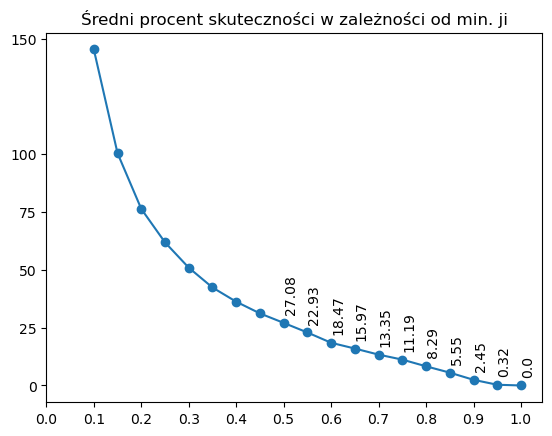

In [117]:
plot_data = []

for key in ji_index_results:
    if key == "p" or key < 0.1:
        continue

    precent_list = []
    for index, value in enumerate(ji_index_results[key]):
        precent = value*100/ji_index_results["p"][index]
        precent_list.append(precent)

    plot_data.append(sum(precent_list)/len(precent_list))

plt.plot(
    [x/100 for x in range(0, 101, 5)][2:],
    plot_data,
    "-o"
    )

plt.title("Średni procent skuteczności w zależności od min. ji")
plt.xticks([x/100 for x in range(0, 101, 10)])
plt.yticks([150, 100, 75, 50, 25, 0])

for a,b in zip([x/100 for x in range(0, 101, 5)][-11:], plot_data[-11:]): 
    plt.text(a, b+5, str(round(b, 2)), rotation=90)

# plt.legend()
plt.show()


Min Jaccard Index value: 0.0


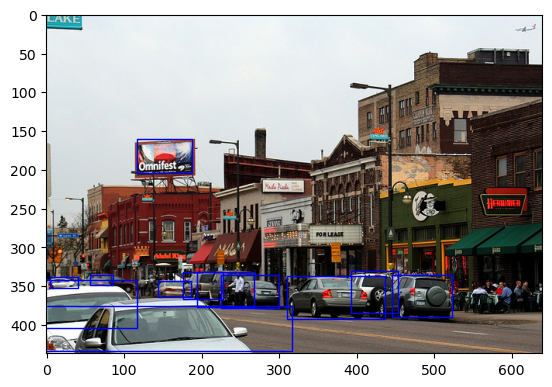

Min Jaccard Index value: 0.05


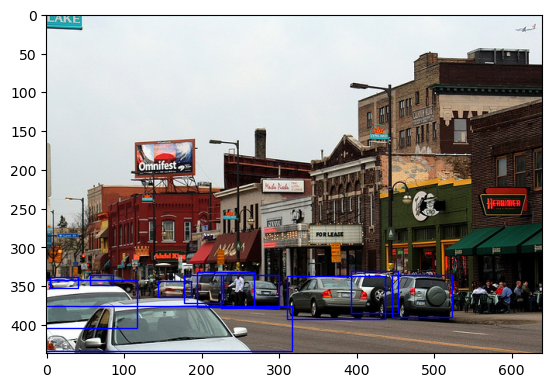

Min Jaccard Index value: 0.1


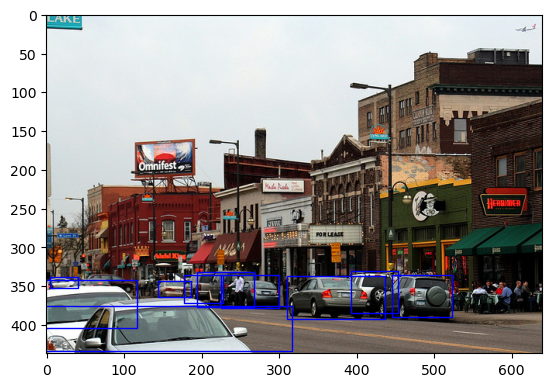

Min Jaccard Index value: 0.15


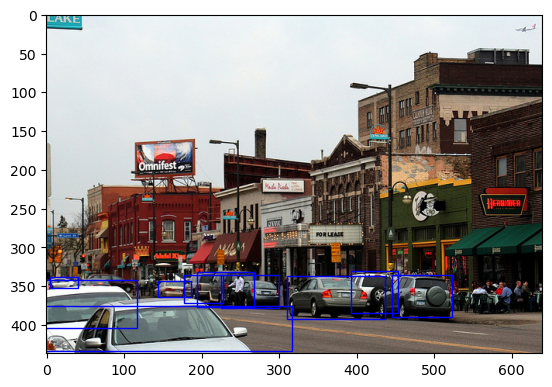

Min Jaccard Index value: 0.2


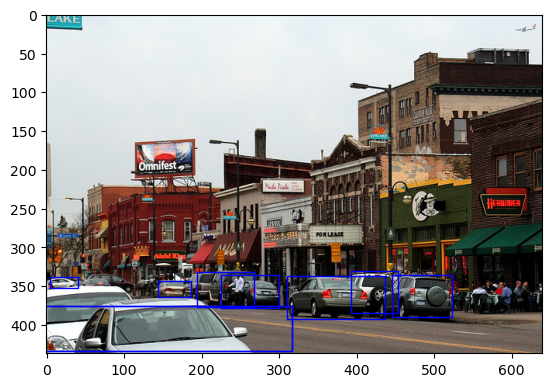

Min Jaccard Index value: 0.25


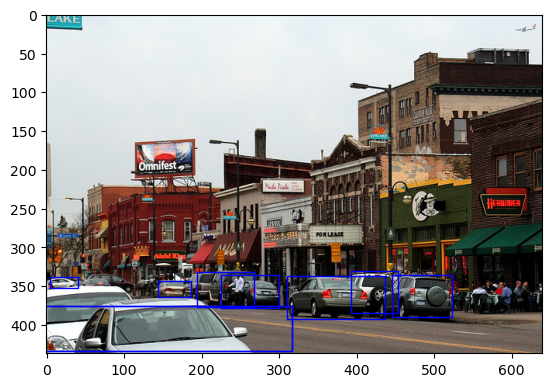

Min Jaccard Index value: 0.3


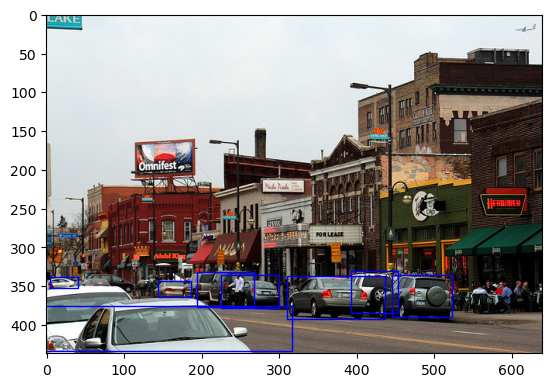

Min Jaccard Index value: 0.35


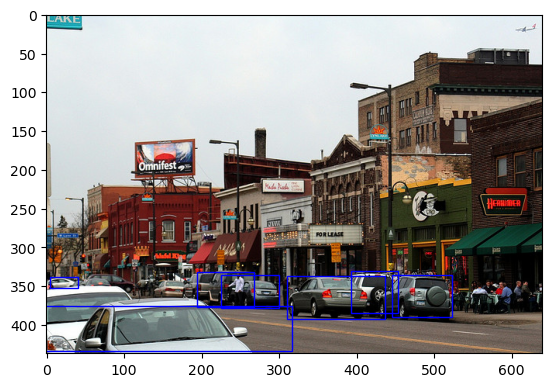

Min Jaccard Index value: 0.4


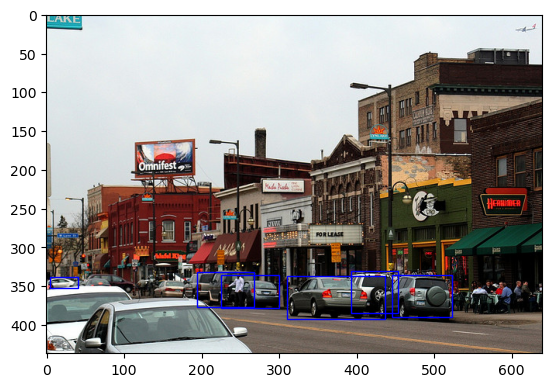

Min Jaccard Index value: 0.45


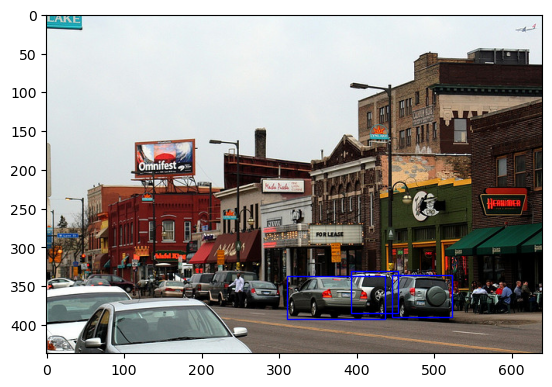

Min Jaccard Index value: 0.5


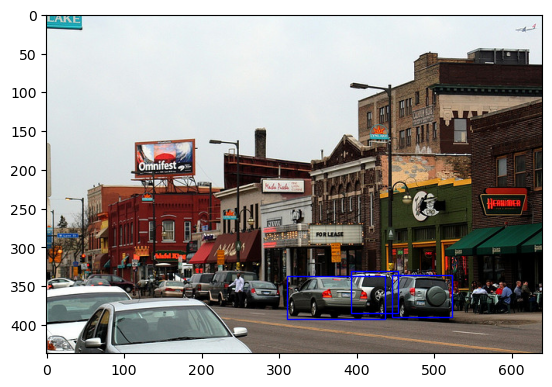

Min Jaccard Index value: 0.55


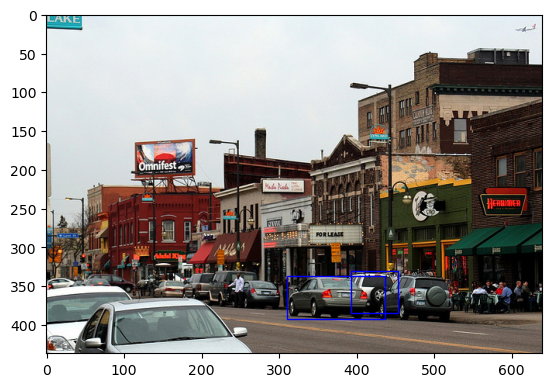

Min Jaccard Index value: 0.6


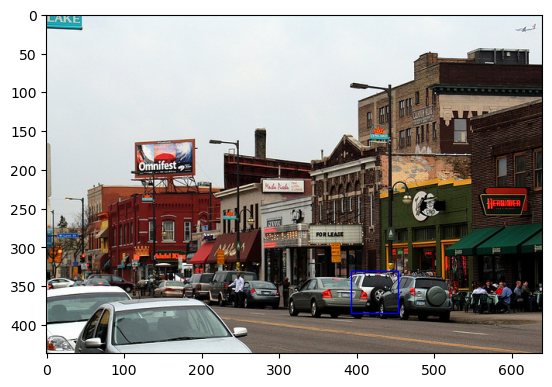

Min Jaccard Index value: 0.65


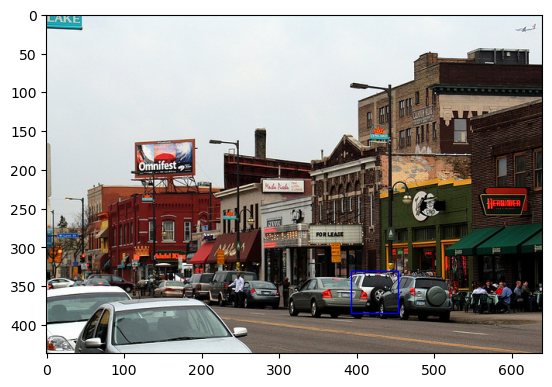

Min Jaccard Index value: 0.7


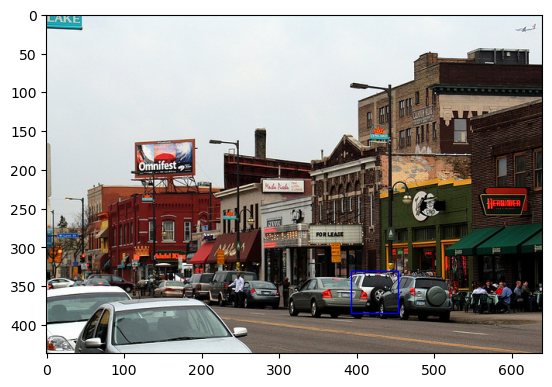

Min Jaccard Index value: 0.75


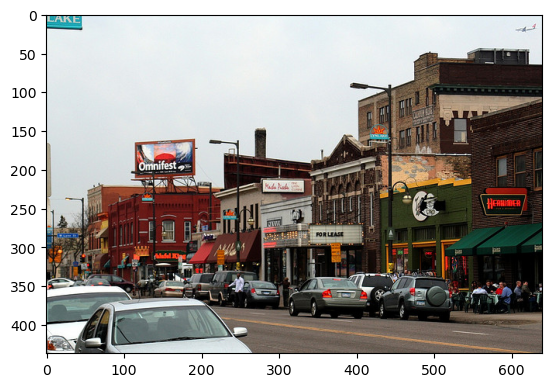

Min Jaccard Index value: 0.8


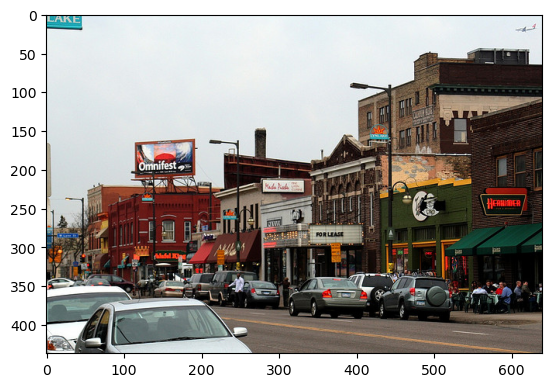

Min Jaccard Index value: 0.85


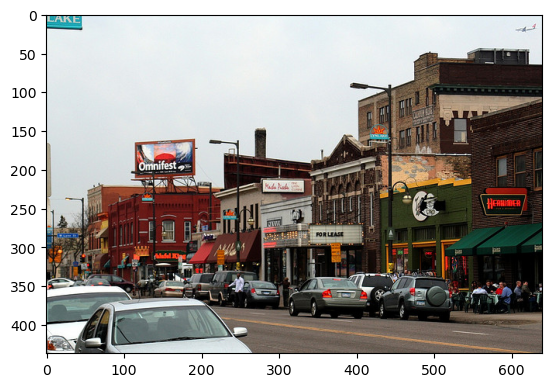

Min Jaccard Index value: 0.9


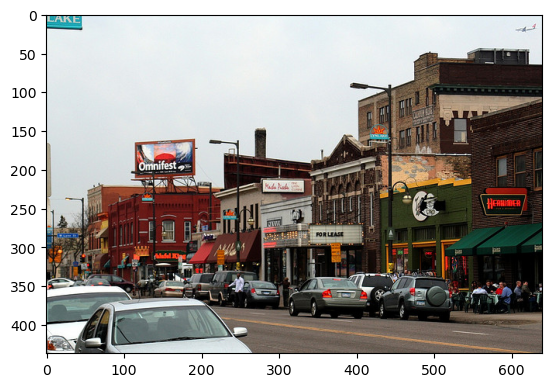

Min Jaccard Index value: 0.95


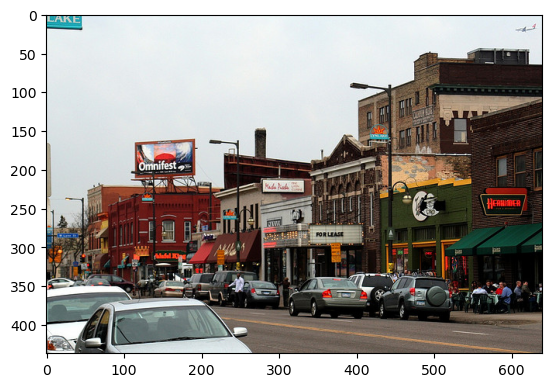

Min Jaccard Index value: 1.0


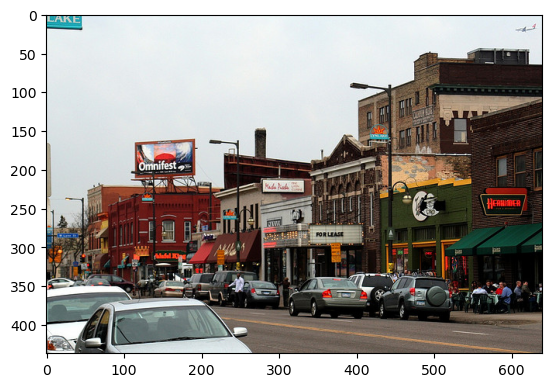

In [30]:
for min_ji_index in [x/100 for x in range(0, 101, 5)]:
    print("Min Jaccard Index value:", min_ji_index)

    # precent_list = []
    # for index, value in enumerate(ji_index_results[min_ji_index]):
        # precent = value*100/ji_index_results["p"][index]
        # precent_list.append(precent)
    # print("Avg percentage:", sum(precent_list)/len(precent_list))

    mmdet_rects = get_mmdet_rects("./coco/images/000000039484.jpg", model, False, min_ji_index)
    coco_rects = get_coco_rects(files["000000039484.jpg"])

    f_coco, f_mmdet, _, _ = filter_rectangles(coco_rects, mmdet_rects, min_ji_index)
    pairs = [(f_coco[i], f_mmdet[i]) for i in range(len(f_coco))]
    cleared_rects = clear_duplicates(pairs)
    
    coco_ = []
    mmdet_ = []
    for c, m in cleared_rects:
        coco_.append(c)
        mmdet_.append(m)

    draw_rectangles("./coco/images/000000039484.jpg", [], mmdet_)

# TODO: Non maximum Supresion


In [ ]:
)
    # draw_rectangles("./coco/images/000000017627.jpg", [], get_mmdet_rects("./coco/images/000000017627.jpg", model, False, min_ji_index))
